In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 楕円データと真値パラメータの読み込み
ellipse_points = [] # 点の座標
true_param = [] # パラメータの真値
with open('points.dat') as f:
    content = f.readlines()
    for line in content:
        line_list = line.split()
        ellipse_points.append((float(line_list[0]), float(line_list[1]))) # (X, Y)
with open('true_param.dat') as f:
    content = f.readlines()
    for line in content:
        true_param.append(float(line))

In [3]:
# 座標列と定数f0からξを求める
def calc_xi(points, f0):
    xi = []
    for p in points:
        a = p[0] * p[0]
        b = 2 * p[0] * p[1]
        c = p[1] * p[1]
        d = 2 * f0 * p[0]
        e = 2 * f0 * p[1]
        f = f0 * f0
        xi.append(np.array([[a, b, c, d, e, f]]).T)
    return xi

In [4]:
# 座標列と定数f0から各座標のV[ξ_α]を求める
def calc_V_xi(points, f0):
    V_xi = []
    for p in points:
        x = p[0]
        y = p[1]
        V_xi.append(4 * np.array([[ x * x,         x * y,      0,  f0 * x,       0, 0],
                                  [ x * y, x * x + y * y,  x * y,  f0 * y,  f0 * x, 0],
                                  [     0,         x * y,  y * y,       0,  f0 * y, 0],
                                  [f0 * x,        f0 * y,      0, f0 * f0,       0, 0],
                                  [     0,        f0 * x, f0 * y,       0, f0 * f0, 0],
                                  [     0,             0,      0,       0,       0, 0]]))
    return V_xi

In [5]:
# 最小二乗法
def least_square(points, f0 = 600):
    xi = calc_xi(points, f0)
    M = np.zeros([len(xi[0]), len(xi[0])])
    for xi_a in xi:
        M += np.dot(xi_a, xi_a.T)
    e_val, e_vec = np.linalg.eig(M)
    smallest_idx = e_val.argmin()
    smallest_vec = e_vec[:, smallest_idx]
    return smallest_vec / np.linalg.norm(smallest_vec)

In [6]:
# FNS法による最尤推定
def maximum_likelihood(points, f0 = 600):
    u = np.array(least_square(points, f0)) # 初期値
    xi = calc_xi(points, f0)
    V_xi = calc_V_xi(points, f0)
    diff = 1.0
    EPS = 1e-9
    iter_limit = 100
    iter_count = 0
    while diff > EPS:
        M = np.zeros([len(xi[0]), len(xi[0])])
        L = np.zeros([len(xi[0]), len(xi[0])])
        for a, xi_a in enumerate(xi):
            prod_u_xi = np.dot(u, xi_a)
            div = np.dot(u, np.dot(V_xi[a], u))
            M += np.dot(xi_a, xi_a.T) / div
            L += prod_u_xi * V_xi[a] / div / div
        e_val, e_vec = np.linalg.eig(M)
        smallest_idx = e_val.argmin()
        smallest_vec = e_vec[:, smallest_idx] / np.linalg.norm(e_vec[:, smallest_idx])
        diff = min(np.linalg.norm(smallest_vec - u), np.linalg.norm(smallest_vec + u))
        u = smallest_vec
        iter_count += 1
        if iter_count > iter_limit: break
    return u

In [7]:
# 誤差を求める
def calc_diff(params, true_param = true_param, f0 = 600):
    u = np.array([true_param]).T
    p = np.identity(len(true_param)) - np.dot(u, u.T)
    diff = np.dot(p, params)
    return diff

In [8]:
# 指定した分散の指定した方法による偏差と平方平均二乗誤差を求める
def calc_range_rms(spread, samples, method):
    total = 0.0
    total_raw = np.zeros([6, 6])
    for i in range(samples):
        noisy_ellipse_points = []
        for point in ellipse_points:
            noisy_ellipse_points.append((point[0] + np.random.normal(scale=spread), point[1] + np.random.normal(scale=spread)))
        param = method(noisy_ellipse_points, 600)
        diff = calc_diff(param)
        total += np.linalg.norm(diff) ** 2
        total_raw += diff
    dev = np.linalg.norm(total_raw / samples)
    rms = np.sqrt(total / samples)
    return (dev, rms)

In [9]:
# σ=[0, 1]の範囲を、0.001ずつ変化させながらそれぞれ1000回試行して、平方平均二乗誤差を求める
# 時間がかかるので並列化
from joblib import Parallel, delayed

start = 0
end = 1
delta = 0.001
samples = 1000

x = np.linspace(start, end, int((end - start) / delta) + 1)
y_ls = Parallel(n_jobs=-1, verbose=5)([delayed(calc_range_rms)(spread, samples, least_square) for spread in x])
y_ml = Parallel(n_jobs=-1, verbose=5)([delayed(calc_range_rms)(spread, samples, maximum_likelihood) for spread in x])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed:   43.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1

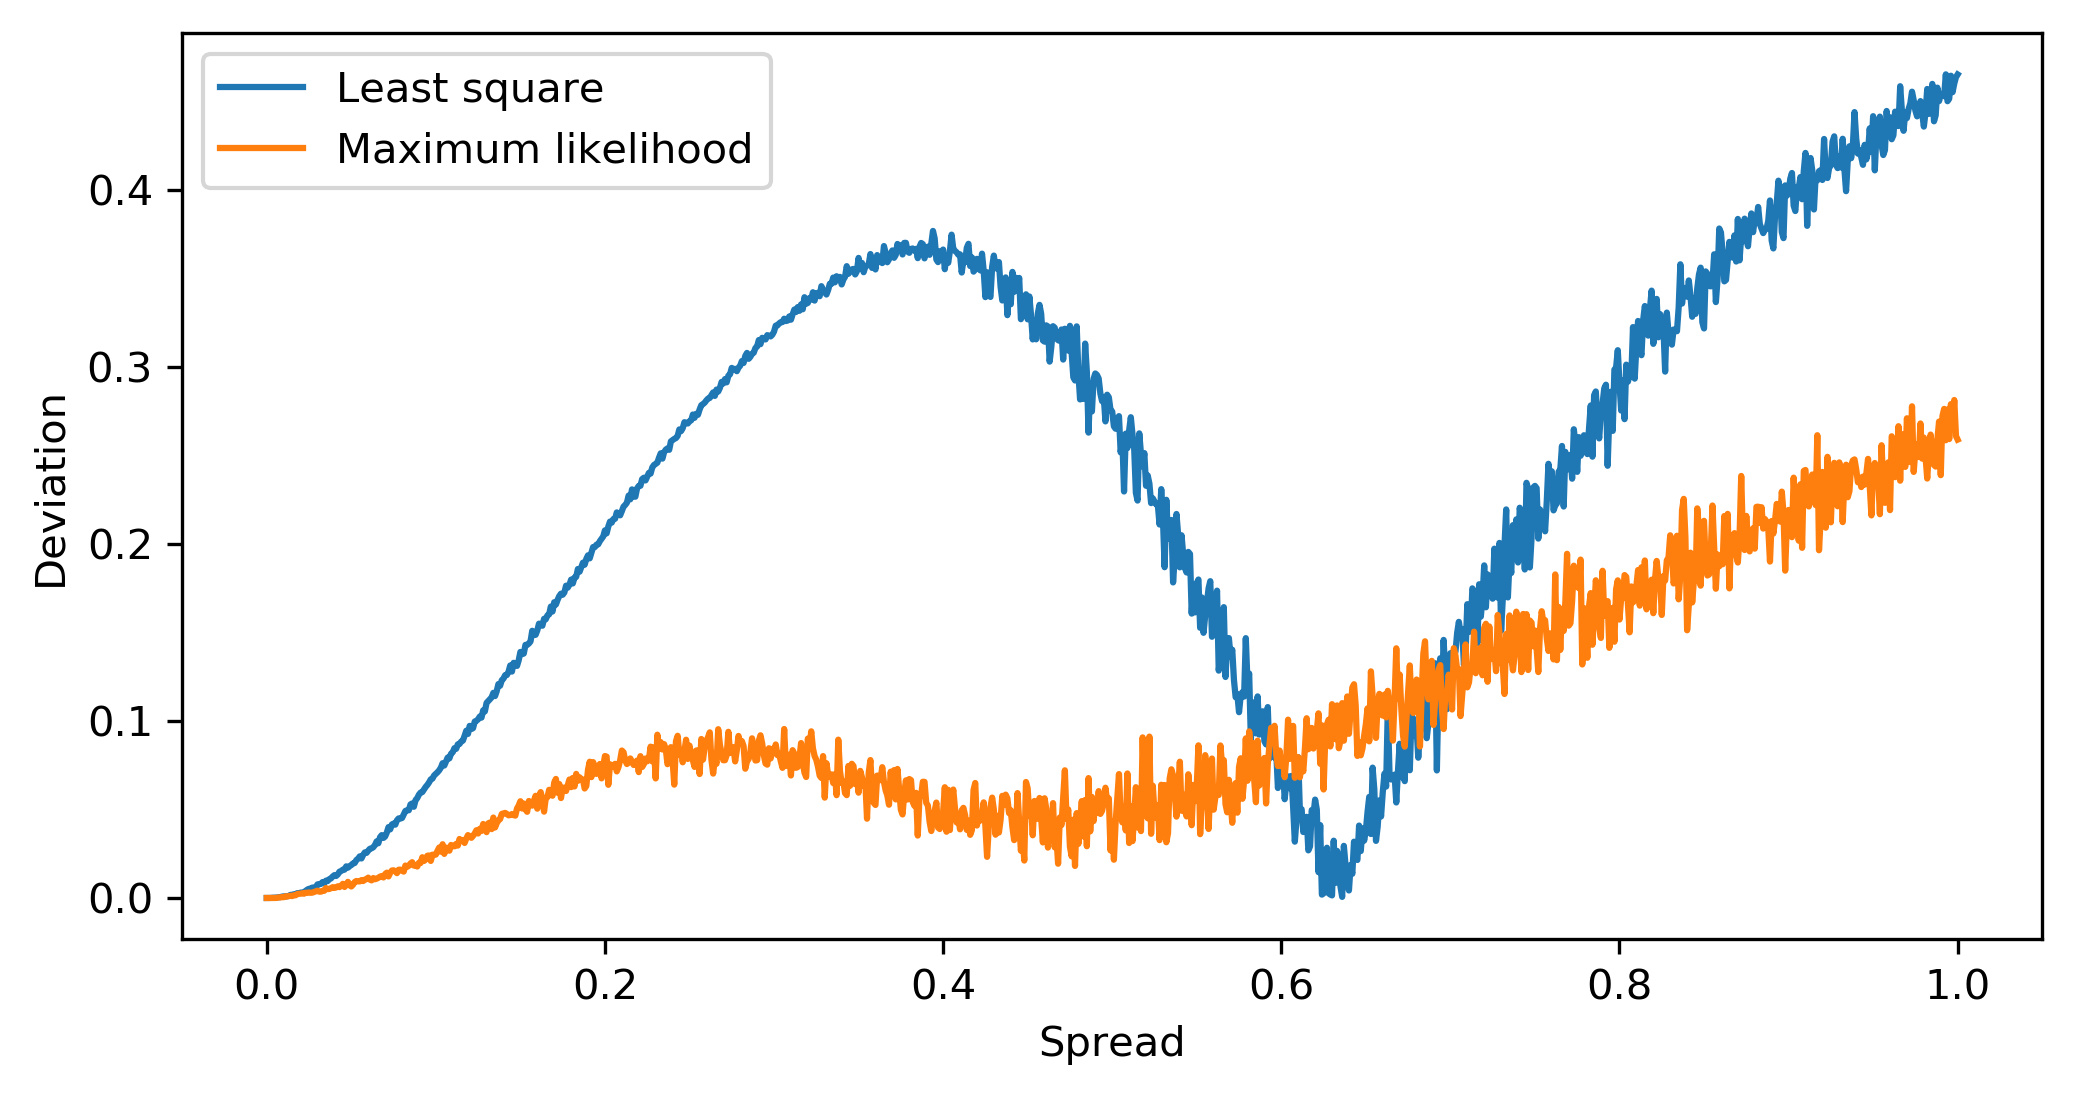

In [10]:
f = plt.figure(figsize=(8, 4), dpi=300)
f.add_subplot(1, 1, 1)
plt.plot(x, np.array(y_ls)[:, 0].tolist(), label='Least square')
plt.plot(x, np.array(y_ml)[:, 0].tolist(), label='Maximum likelihood')
plt.xlabel('Spread')
plt.ylabel('Deviation')
plt.legend()
plt.savefig('deviation_comparison.png')
plt.show()

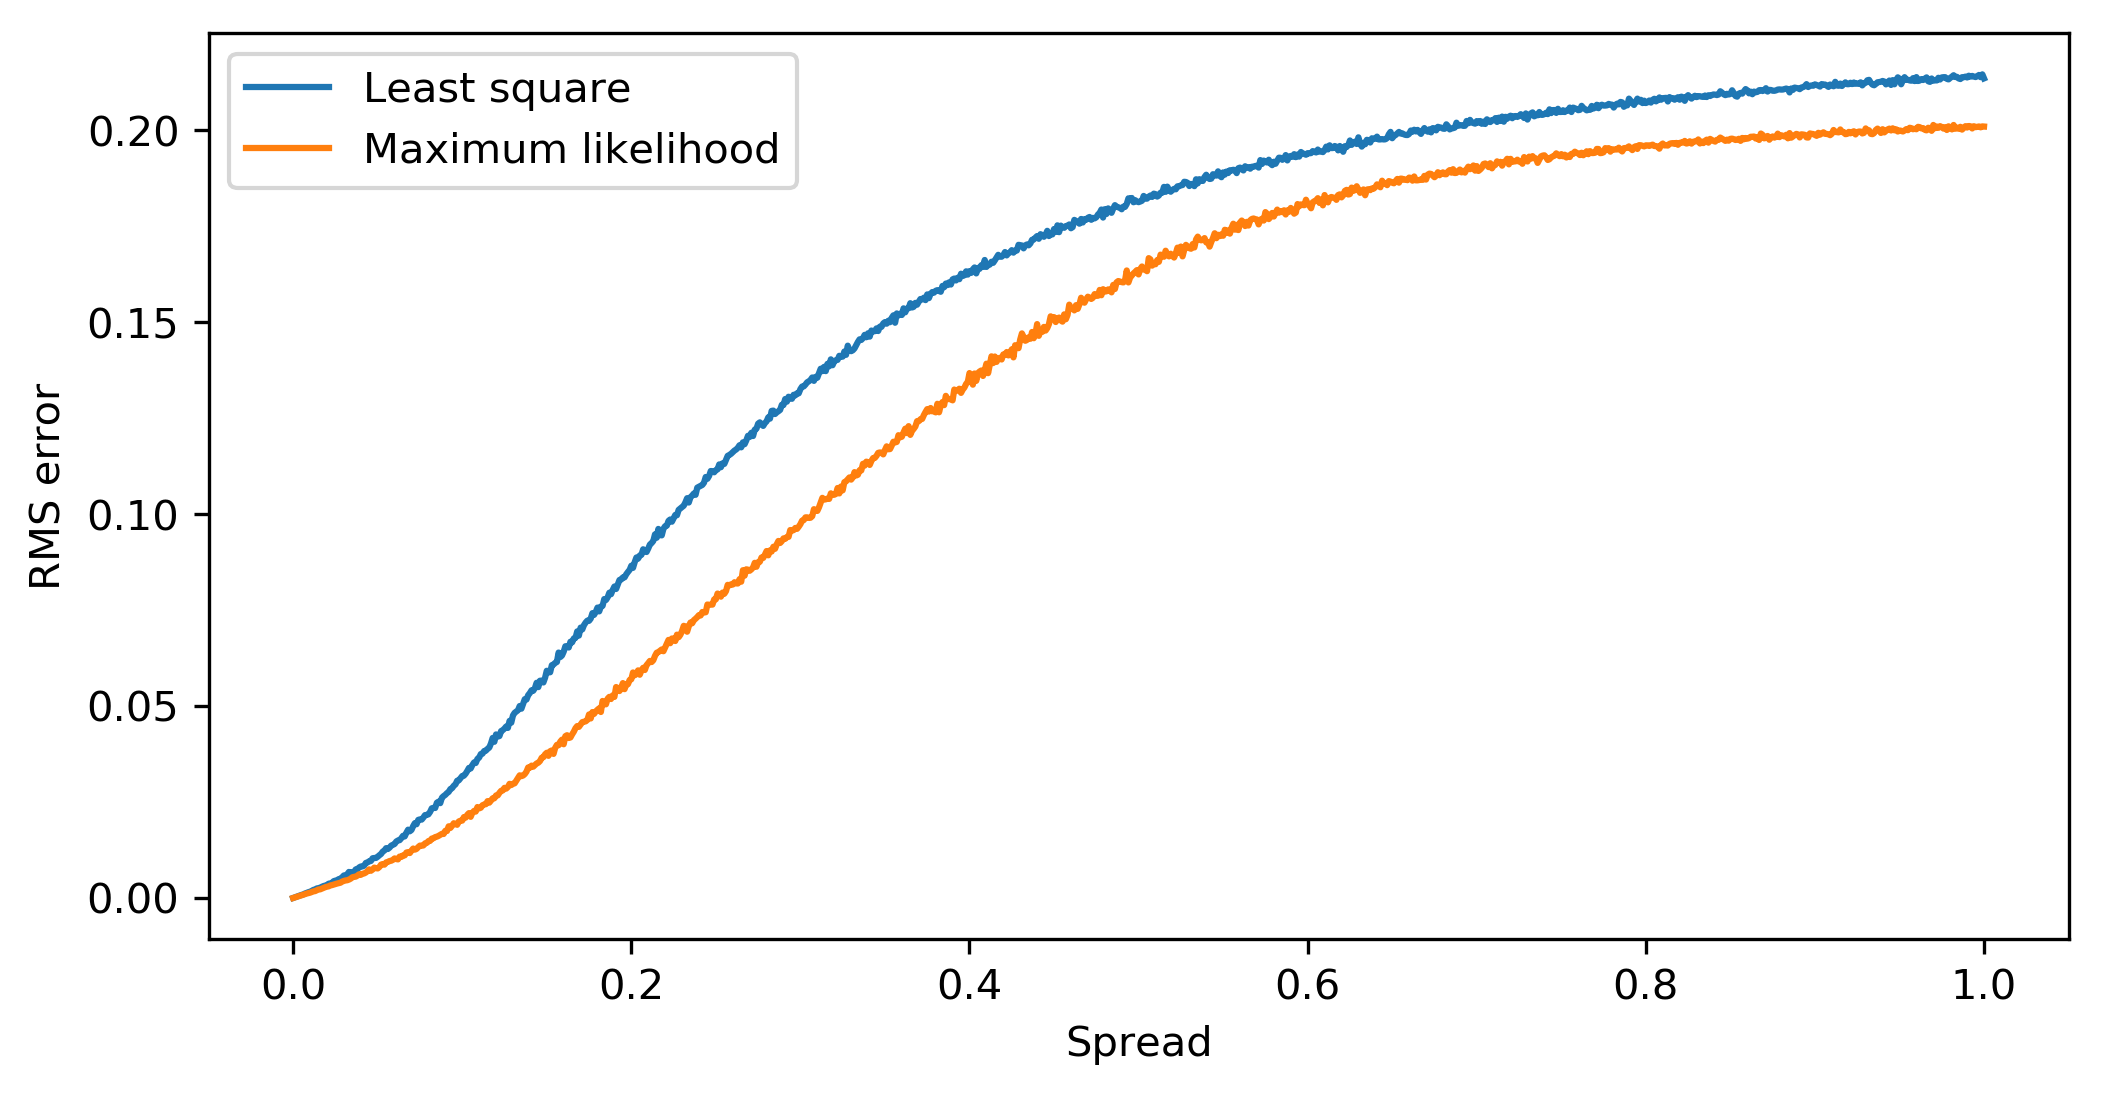

In [11]:
f = plt.figure(figsize=(8, 4), dpi=300)
f.add_subplot(1, 1, 1)
plt.plot(x, np.array(y_ls)[:, 1].tolist(), label='Least square')
plt.plot(x, np.array(y_ml)[:, 1].tolist(), label='Maximum likelihood')
plt.xlabel('Spread')
plt.ylabel('RMS error')
plt.legend()
plt.savefig('rms_comparison.png')
plt.show()

In [12]:
# 参考: http://daily-tech.hatenablog.com/entry/2018/04/13/084734

from sympy import *
import sympy
import numpy as np
import matplotlib.pyplot as plt
import math

def generateVecFromEllipse(axis, center, T, rng=[0, 2*math.pi], num=1001):

    t = np.linspace(rng[0], rng[1], num) 
    t = np.reshape(t, (t.shape[0], 1))

    xVec = np.zeros((t.shape))
    yVec = np.zeros((t.shape))
    for i in range(t.shape[0]):
        xVec[i] = axis[0, 0] * math.cos(t[i])
        yVec[i] = axis[1, 0] * math.sin(t[i])

    dataTmp = np.concatenate((xVec, yVec),  axis=1)
    dataTmp = T * dataTmp.T
    dataTmp = dataTmp.T
    dataTmp[:, 0] =  dataTmp[:, 0] + center[0, 0]
    dataTmp[:, 1] =  dataTmp[:, 1] + center[1, 0]

    return dataTmp

def getEllipseProperty(A, B, C, D, E, F):

    if A < 0:
        A = -A
        B = -B
        C = -C
        D = -D
        E = -E
        F = -F   

    # Spectral Decomposition
    M = np.matrix([[A, B/2], [B/2, C]])
    lamdas, v = np.linalg.eigh(M)

    # Diagonalize Coeffs Matrix
    DiagA = v.T * M * v  

    # Apply translation for 1st order term.
    tmp = np.matrix([D, E]) * v

    # Calculate coefficient in rotated coords
    AA = DiagA[0, 0]
    BA = DiagA[0, 1] + DiagA[1, 0]
    CA = DiagA[1, 1]
    DA = tmp[0, 0]
    EA = tmp[0, 1]
    scale = F - DA**2 / (4*AA) - EA**2 / (4*CA)

    # Normalize coeffs wrt to constant term.
    AA = AA / abs(scale)
    BA = BA / abs(scale)
    CA = CA / abs(scale)
    DA = DA / abs(scale)
    EA = EA / abs(scale)
    FA = abs(scale) / abs(scale)

    # Ellipse Property Extraction
    a = 1 / math.sqrt(abs(lamdas[0] / scale))
    b = 1 / math.sqrt(abs(lamdas[1] / scale))

    T = np.matrix([[v[0, 0], v[0, 1]], [v[1, 0], v[1, 1]]]) 
    trans = v.T * np.matrix([[-DA/(2*AA)], [-EA/(2*CA)]])

    valid = True
    if AA * CA < 0:
        valid = False

    return valid, np.matrix([[a], [b]]), trans, T

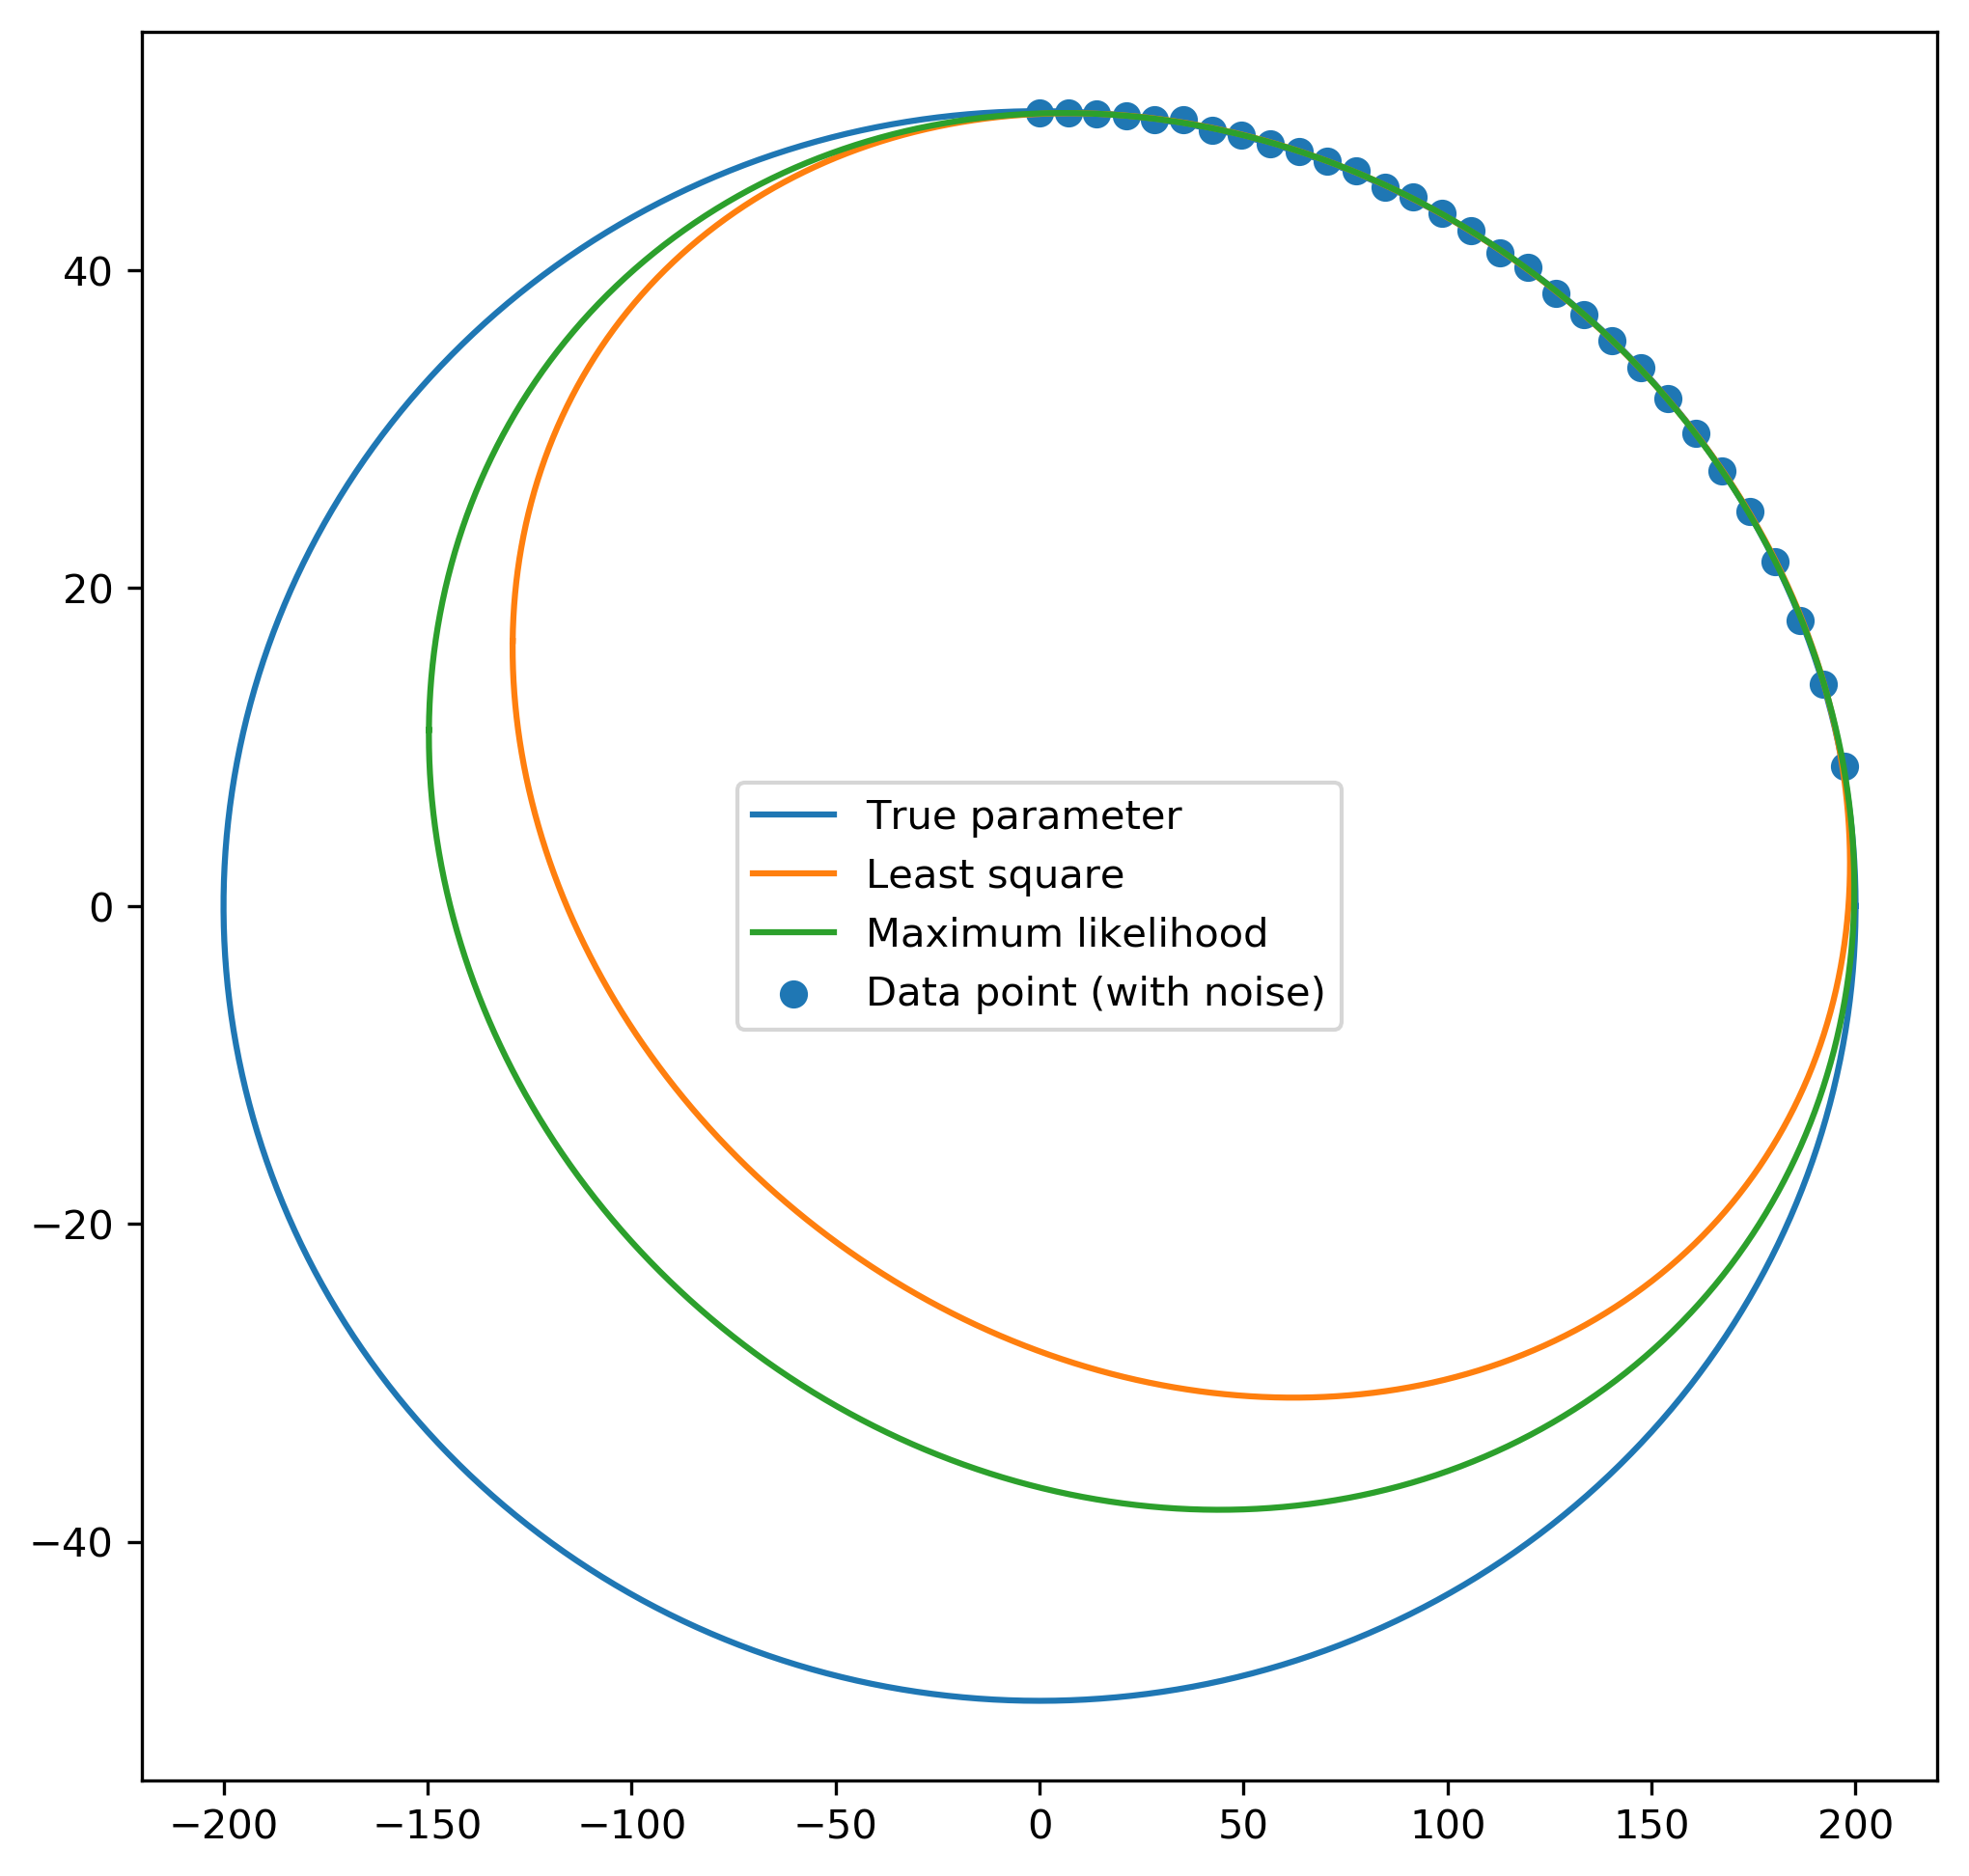

In [16]:
# 楕円のグラフを描画

noisy_ellipse_points = []
for point in ellipse_points:
    noisy_ellipse_points.append((point[0] + np.random.normal(scale=0.1), point[1] + np.random.normal(scale=0.1)))
f0 = 600
param_ls = least_square(noisy_ellipse_points, f0)
param_ml = maximum_likelihood(noisy_ellipse_points, f0)
valid_tr, axis_tr, centerEst_tr, Rest_tr = getEllipseProperty(true_param[0], 2 * true_param[1], true_param[2], 2 * f0 * true_param[3], 2 * f0 * true_param[4], f0 * f0 * true_param[5])
valid_ls, axis_ls, centerEst_ls, Rest_ls = getEllipseProperty(param_ls[0], 2 * param_ls[1], param_ls[2], 2 * f0 * param_ls[3], 2 * f0 * param_ls[4], f0 * f0 * param_ls[5])
valid_ml, axis_ml, centerEst_ml, Rest_ml = getEllipseProperty(param_ml[0], 2 * param_ml[1], param_ml[2], 2 * f0 * param_ml[3], 2 * f0 * param_ml[4], f0 * f0 * param_ml[5])
dataEst_tr = generateVecFromEllipse(axis_tr, centerEst_tr, Rest_tr)
dataEst_ls = generateVecFromEllipse(axis_ls, centerEst_ls, Rest_ls)
dataEst_ml = generateVecFromEllipse(axis_ml, centerEst_ml, Rest_ml)
f = plt.figure(figsize=(8, 8), dpi=300)
f.add_subplot(1, 1, 1)
plt.scatter(np.array(noisy_ellipse_points)[:, 0].tolist(), np.array(noisy_ellipse_points)[:, 1].tolist(), label='Data point (with noise)')
plt.plot(dataEst_tr[:, 0], dataEst_tr[:, 1], label='True parameter')
plt.plot(dataEst_ls[:, 0], dataEst_ls[:, 1], label='Least square')
plt.plot(dataEst_ml[:, 0], dataEst_ml[:, 1], label='Maximum likelihood')
plt.legend()
plt.savefig('ellipse_comparison.png')
plt.show()

In [20]:
print(f'True parameter: {true_param}')
spread_list = [0.0, 0.1, 0.5, 1.0]
for spread in spread_list:
    noisy_ellipse_points = []
    for point in ellipse_points:
        noisy_ellipse_points.append((point[0] + np.random.normal(scale=spread), point[1] + np.random.normal(scale=spread)))
    f0 = 600
    param_ls = least_square(noisy_ellipse_points, f0)
    param_ml = maximum_likelihood(noisy_ellipse_points, f0)
    print(f'Spread = {spread}:')
    print(f'Least square: {param_ls}')
    print(f'Maximum likelihood: {param_ml}')

True parameter: [0.06237678795565935, 0.0, 0.9980286072905497, 0.0, 0.0, -0.006930754217295484]
Spread = 0.0:
Least square: [-6.23767880e-02 -5.38623986e-11 -9.98028607e-01  5.20383758e-12
  2.51616810e-11  6.93075421e-03]
Maximum likelihood: [ 6.23767880e-02  2.43612633e-12  9.98028607e-01 -2.24265417e-13
 -1.17304201e-12 -6.93075422e-03]
Spread = 0.1:
Least square: [-0.06011952 -0.02579058 -0.99777092  0.00248399  0.01196464  0.00493449]
Maximum likelihood: [-0.06147144 -0.01917595 -0.99787175  0.0018846   0.0084539   0.00552204]
Spread = 0.5:
Least square: [-0.04070097 -0.16553747 -0.98192161  0.01575365  0.08048654 -0.00666787]
Maximum likelihood: [-0.04604506 -0.16532767 -0.98210129  0.01568544  0.07578506 -0.00585251]
Spread = 1.0:
Least square: [ 0.0379246   0.19488992  0.97543929 -0.01852605 -0.09314814  0.00883448]
Maximum likelihood: [-0.0322069  -0.17922247 -0.97858546  0.017085    0.09401876 -0.00900519]
